Quick tools for generating polynomial approximations to arbitrary functions
==============================

So, frequently, on graphics twitter, a discussion will come up about finding a "good" approximation
to some function like 

$$cos(acos(t)/3)$$

or

$$f(x) = \over{x}{x+1}$$

on some range, usually $[0,1]$.

What does "good" mean?
---------------------------------------

Well, there are entire families of methods to cook up polynomial approximations to functions.

In this notebook, we focus on a technique that minimizes mean squared error (MSE).

It's not the only thing we can minimize.

But it's one of the easiest things to minimize.

And we can do it in almost closed form for surprisingly arbitrary choices of functions to approximate.

So, how do we do it?
--------------------------------

Imagine you have a function $f(x)$ and you want to cook up a $g(x) = \sum_{i=0}^n \alpha_i x^i$ that minimizes
$ \int_a^b (f(x) - g(x))^2 dx$ over some interval $(a,b)$.

Now, if you write that whole thing out, you get

$$\sum_{i=0}^n \sum_{j=0}^n \int_a^b \alpha_i \alpha_j x^{j+i}dx -
\sum_{i=0}^n 2 \int_a^b \alpha_i x^i f(x) dx +
\int_a^b f(x)^2 dx
$$

That looks messy, but it turns out the whole thing can be written as a matrix expression that expresses the MSE
of our approximation function in terms of the sequence of $\alpha_i, i \in 0..n$

It kind of looks like

$$ MSE(\alpha) = \alpha^T A \alpha - 2 B \alpha + C$$

where $\alpha$ is the vector of $\alpha_i$, 
$A_{i,j} = \int_a^b x^{j+i}dx = {{(b^{j+i+1} - a^{j+1+1})}\over{j+i+1}}$,
$B_i = \int_a^b f(x) x^i dx$ (often has to be computed numerically)
and $C = \int_a^b f(x)^2 dx$

We can minimize it by using the standard least-squares trick of setting the gradient to zero, and solving

$A \alpha - B = 0$ or $A \alpha = B$ 

Where do I learn more?
------------------------------------

I've been told that this is a standard technique, but, having stumbled upon it by re-inventing the wheel,
I don't know what the standard name for it is.

It's closely related to least-squares regression.  Maybe it's just called "least squares regression".  Or maybe
it's called something like "least squares regression with (word for one of the tricks being used here)"

In [177]:
import numpy as np
from matplotlib import pyplot as plt

Helper functions
------------------------

`integrate` here is something you might want to consider replacing with your own function if you happen
to know a trick for integrating $\int_a^b f(x) x^i dx$ for your $f(x)$ and for arbitrary $i$

It is called by `get_b`.

`get_a`, `get_b` and `get_c` get the $A$, $B$, and $C$ matrices described above.

Except that $C$ isn't really needed for subsequent computations, and `get_b` actually returns $-2B$ instead of $B$

In [39]:
def integrate(f, bounds=[0.0, 1.0], nsteps=10000):
    w = bounds[1] - bounds[0]
    h = w / nsteps
    start = bounds[0] + 0.5 * h
    xs = [h*i + start for i in range(nsteps)]
    areas = [f(x) * h for x in xs]
    return sum(areas)

In [40]:
def get_a(n, bounds=[0.0, 1.0]):
    x0 = bounds[0]
    x1 = bounds[1]
    els = [[(x1 **  (i + j + 1) - x0 ** (i + j + 1))/(i+j+1) for j in range(n)] for i in range(n)]
    return np.array(els)

def get_b(n, f, bounds=[0.0, 1.0], nsteps=10000):
    els = [-2.0 * integrate(lambda x: x**i * f(x), bounds=bounds, nsteps=nsteps) for i in range(n)]
    return np.array(els)

def get_c(f):
    return integrate(lambda x: f(x)*f(x))

In [41]:
def solve_coeffs(a,b,_c):
    return np.linalg.solve(a, -0.5*b)

How to expose our solutions?
-----------------------------

Because the obvious use-case for this is to print out an expression that can be cut-and-paste
into computer graphics code in some language other than python, we choose a style of writing the polynomial
analogous to "Horner's method" so that it can be expressed entirely with `+`, `*`, `x`, and constants.

In [43]:
def horner(x, coeffs):
    pow_accum = 1.0
    accum = 0.0
    for c in coeffs:
        accum += pow_accum * c
        pow_accum *= x
    return accum

In [47]:
def horner_string(coeffs):
    accum = ""
    r_accum = ""
    for c in coeffs[:-1]:
        accum += "({:.15f} + x*".format(c)
        r_accum += ")"
    accum += "{:.15f}".format(coeffs[-1])
    return accum + r_accum

In [63]:
def solve(f, degree, bounds=[0.0, 1.0], n_integration_steps=10000):
    A = get_a(degree+1, bounds=bounds)
    B = get_b(degree+1, f, bounds=bounds, nsteps=n_integration_steps)
    coeffs = solve_coeffs(A, B, None)
    f_approx = lambda x: horner(x, coeffs)
    xs = [bounds[0] + (bounds[1] - bounds[0]) * i / n_integration_steps for i in range(n_integration_steps)]
    plt.plot(xs, [f(x) for x in xs], 'b-')
    plt.plot(xs, [f_approx(x) for x in xs], 'r-.')
    print(horner_string(coeffs))
    mse = integrate(lambda x: (f_approx(x) - f(x))**2, bounds=bounds, nsteps=n_integration_steps)
    mse = mse/(bounds[1] - bounds[0])
    print("MSE is {:f}".format(mse))

Examples
--------

Now that we've built this thing, let's try it out!

Some of the examples below are things for which quick approximations are often sought
in computer graphics.  Some are things that `@iquilezles` or `@Atrix256` have discussed polynomial approximations
for on twitter.

Note that a frequent complaint about approximations cooked up with this method is that they don't interpolate endpoints.

A fix for that is presented after these examples

(0.013961456441606 + x*(0.804049690957671 + x*-0.327400446503659))
MSE is 0.000019


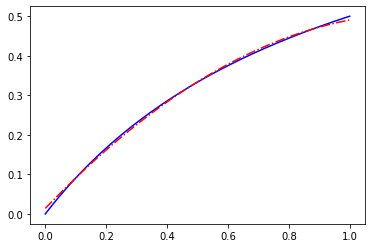

In [64]:
f = lambda x: x/(x+1)
solve(f, 2)

(0.002721517318214 + x*(0.938928960438372 + x*(-0.664598620205411 + x*0.224798782467834)))
MSE is 0.000001


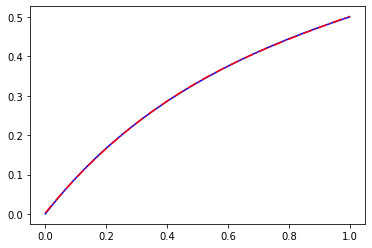

In [65]:
solve(f, 3)

(0.068528197525549 + x*0.476649244454012)
MSE is 0.000614


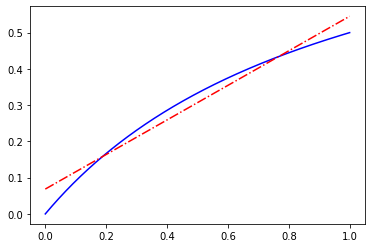

In [66]:
solve(f, 1)

(0.303447666476664 + x*(0.347717512645012 + x*(-3.553070091873221 + x*3.982981984249812)))
MSE is 0.186533


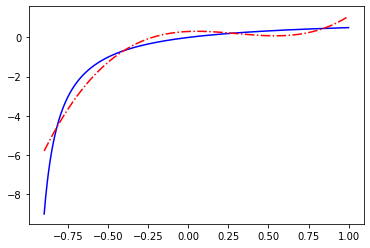

In [67]:
solve(f, 3, bounds=[-0.9,1]) # goes near a singularity

(0.870117144366509 + x*(0.155095193983420 + x*(-0.079101328054017 + x*0.062936403380600)))
MSE is 0.000041


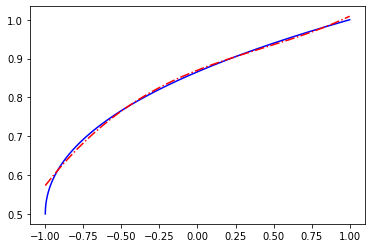

In [84]:
solve(lambda x: np.cos(np.arccos(x)/3), 3, bounds=[-1,1])

(0.864555391677718 + x*(0.155095193983420 + x*(-0.023483801166103 + x*(0.062936403380600 + x*-0.064887114702567))))
MSE is 0.000017


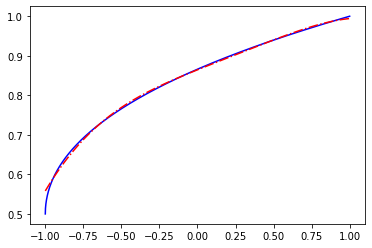

In [87]:
solve(lambda x: np.cos(np.arccos(x)/3), 4, bounds=[-1,1])

(0.085449328808571 + x*(0.000000000000087 + x*(2.307126275098212 + x*(-0.000000000000735 + x*(-2.819815398341568 + x*(0.000000000001554 + x*(1.466301614122375 + x*-0.000000000000936)))))))
MSE is 0.000509


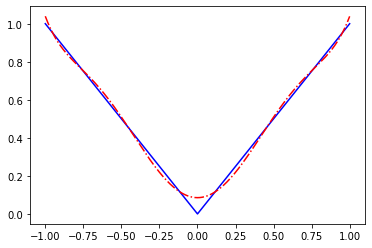

In [69]:
solve(lambda x: abs(x), 7, bounds=[-1,1])

(-0.000000000000000 + x*(3.103460496603129 + x*(0.000000000000001 + x*(-4.814388730974032 + x*(-0.000000000000001 + x*1.726905637894786)))))
MSE is 0.000018


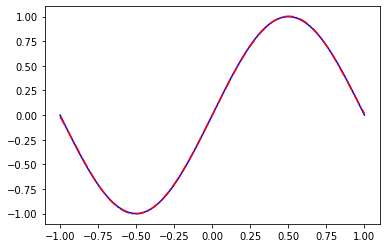

In [70]:
solve(lambda x: np.sin(np.pi * x), 5, bounds=[-1,1])

(0.000000000000001 + x*(2.008197095038624 + x*(-0.000000000000001 + x*(-2.232852181515016 + x*(0.000000000000000 + x*0.453821041078360)))))
MSE is 0.046686


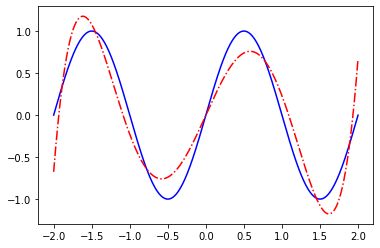

In [71]:
solve(lambda x: np.sin(np.pi * x), 5, bounds=[-2,2])

(0.000000000000002 + x*(2.909032213060851 + x*(-0.000000000000006 + x*(-4.259731197065141 + x*(0.000000000000004 + x*(1.568604499630964 + x*(-0.000000000000001 + x*-0.172526011442668)))))))
MSE is 0.001463


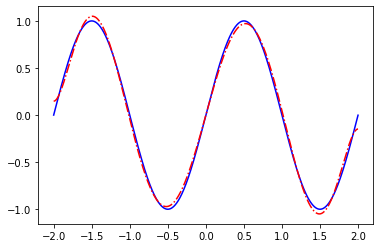

In [74]:
solve(lambda x: np.sin(np.pi * x), 7, bounds=[-2,2])

(0.083918363611151 + x*(2.937021582855697 + x*(-7.831939942650164 + x*(14.097373880972407 + x*(-12.586869947662899 + x*4.307488434884001)))))
MSE is 0.000024


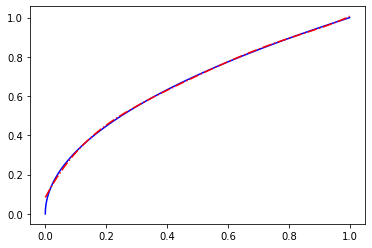

In [72]:
solve(lambda x: np.sqrt(x), 5, bounds=[0,1])

(0.171429108740506 + x*(1.371426454759855 + x*-0.571426826320898))
MSE is 0.000408


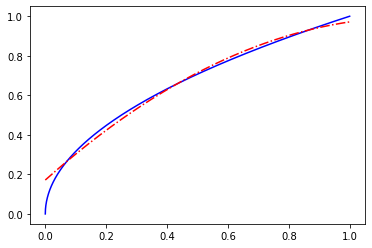

In [73]:
solve(lambda x: np.sqrt(x), 2, bounds=[0,1])

(0.989418064497488 + x*(-0.000000000000001 + x*(-0.322142354505779 + x*(0.000000000000006 + x*(-0.483194363571075 + x*-0.000000000000005)))))
MSE is 0.000269


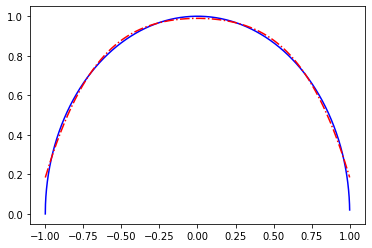

In [79]:
solve(lambda x: np.sqrt(1.0 - x * x), 5, bounds=[-1,1])

(1.010054768091424 + x*(-0.367200305140966 + x*(2.579348497887213 + x*(-9.745455652187395 + x*(12.852818459638542 + x*-6.210233865148290)))))
MSE is 0.000050


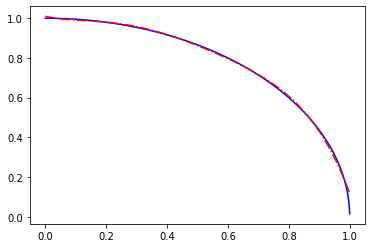

In [80]:
solve(lambda x: np.sqrt(1.0 - x * x), 5, bounds=[0,1])

(0.078125066742717 + x*(-2.281252046007681 + x*(29.531265328168566 + x*(-91.875043587335668 + x*(108.281301890191529 + x*-43.312521805996738)))))
MSE is 0.006104


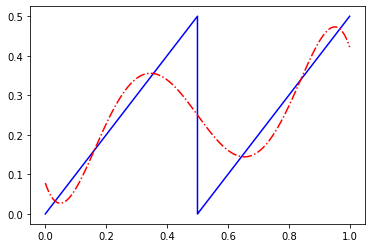

In [77]:
solve(lambda x: np.mod(x, 0.5), 5, bounds=[0,1])

(-0.495321653164403 + x*(78.610358081397393 + x*(-2976.802231943212064 + x*(48747.749434066761751 + x*(-421396.569924201525282 + x*(2118545.954697067849338 + x*(-6378991.709201641380787 + x*(10899719.153942758217454 + x*(-7260372.021865301765501 + x*(-7635417.500231115147471 + x*(16701214.054708126932383 + x*(-1740450.565716905519366 + x*(-22415162.895380906760693 + x*(26979572.793800514191389 + x*(-13507175.761317869648337 + x*2614066.903926628176123)))))))))))))))
MSE is 0.012101


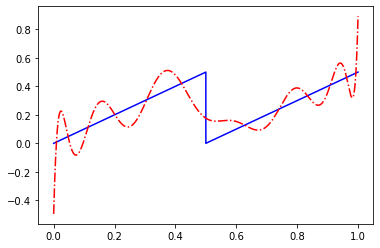

In [78]:
solve(lambda x: np.mod(x, 0.5), 15, bounds=[0,1])

Bonus round : incorporating constraints
======================

A frequent desire is to come up with a polynomial approximation for a function that
minimizes, e.g., the MSE subject to interpolating the endpoints.

It turns out there's a fairly simple transformation to turn the above solution into such a device.

Let $n$ be 1 more than the degree of your polynomial (i.e. the number of coefficients you have to solve for).

Constraining the endpoints (or, hey, any arbitrary sequence of k points) to hit the approximating curve
can be expressed as an affine transformation (matrix + vector) mapping the last $n-k$ coefficients onto the full $n$ coefficients such that the solution at the constraint points matches the function.

I apologize for not writing this part out in as much detail as the parts above, but it should be possible to work through it on your own.  The code is there.

Then if $\alpha_{full} = M \alpha_{fewer} + v$ the expression $\alpha^T A \alpha - 2B \alpha + C$ can be rewritten
as $\alpha_{fewer}^T M^T A M \alpha_{fewer} - 2 (B - v^T M) \alpha_{fewer} + v^T v + C$.

This can be solved in the same way as the earlier matrix quadratic equation, and then $\alpha_{full}$ can be found
from $\alpha_{fewer}$ via $\alpha_{full} = M \alpha_{fewer} + v$

In [178]:
def make_constraint_rows(f, degree, x_vals, f_vals = None):
    if f_vals is None:
        f_vals = [f(x) for x in x_vals]
    lhs = [[x**n for n in range(len(x_vals))] for x in x_vals] # matrix of polynomial terms
    rhs = [[-x**n for n in range(len(x_vals), degree+1)] for x in x_vals]
    rhs = np.array(rhs)
    lhs = np.array(lhs)
    mat_term = np.linalg.solve(lhs, rhs)
    const_offsets = np.linalg.solve(lhs, np.array(f_vals))
    mat_term = np.vstack([mat_term, np.eye(degree + 1 - len(x_vals))])
    const_offsets = np.hstack([const_offsets, np.zeros(degree + 1 - len(x_vals))])
    return (mat_term, const_offsets)

In [154]:
def solve_with_constraints(f, degree, bounds=[0.0, 1.0], constrain_at=None, n_integration_steps=10000):
    if constrain_at is None:
        constrain_at = [x for x in bounds]
    (lin_mat, offset) = make_constraint_rows(f, degree, constrain_at)
    A = get_a(degree+1, bounds=bounds)
    B = get_b(degree+1, f, bounds=bounds, nsteps=n_integration_steps)
    Aprime = np.dot(lin_mat.T, np.dot(A, lin_mat))
    Bprime = np.dot(B, lin_mat) + 2.0 * np.dot(lin_mat.T, np.dot(A, offset))
    coeffs_prime = solve_coeffs(Aprime, Bprime, None)
    coeffs = np.dot(lin_mat, coeffs_prime) + offset
    f_approx = lambda x: horner(x, coeffs)
    xs = [bounds[0] + (bounds[1] - bounds[0]) * i / n_integration_steps for i in range(n_integration_steps+1)]
    plt.plot(xs, [f(x) for x in xs], 'b-')
    plt.plot(xs, [f_approx(x) for x in xs], 'r-.')
    print(horner_string(coeffs))
    mse = integrate(lambda x: (f_approx(x) - f(x))**2, bounds=bounds, nsteps=n_integration_steps)
    mse = mse/(bounds[1] - bounds[0])
    print("MSE is {:f}".format(mse))
    print(",".join([str(t) + "->" + str(f_approx(t)) for t in constrain_at]))
    print("vs")
    print(",".join([str(t) + "->" + str(f(t)) for t in constrain_at]))
    

(0.000000000000000 + x*(2.761904687299738 + x*(-3.428571179657581 + x*1.666666492357842)))
MSE is 0.001285
0->0.0,1->1.0
vs
0->0.0,1->1.0


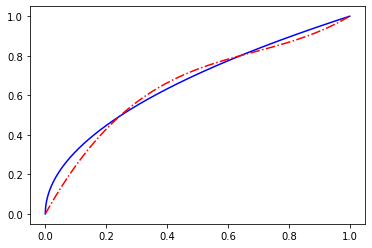

In [155]:
solve_with_constraints(lambda x: np.sqrt(x), 3, bounds=[0,1])

(0.126985126835396 + x*(1.904754237621170 + x*(-1.904746283474184 + x*0.888879638102191)))
MSE is 0.000126


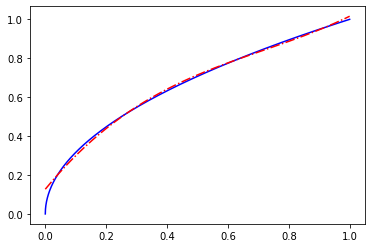

In [156]:
solve(lambda x: np.sqrt(x), 3, bounds=[0,1])

(0.000000000000000 + x*(3.560606324831727 + x*(-7.954547125672469 + x*(9.121215109323837 + x*-3.727274308483095))))
MSE is 0.000497
0->0.0,1->1.0
vs
0->0.0,1->1.0


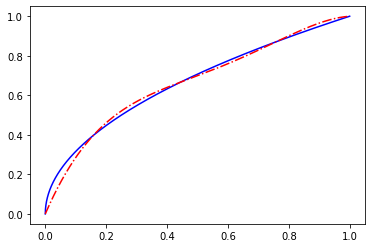

In [157]:
solve_with_constraints(lambda x: np.sqrt(x), 4, bounds=[0,1])

(0.000000000000000 + x*(4.342656648209342 + x*(-14.993000036069951 + x*(29.454523517135417 + x*(-27.188784009800614 + x*9.384603880525805)))))
MSE is 0.000233
0->0.0,1->1.0
vs
0->0.0,1->1.0


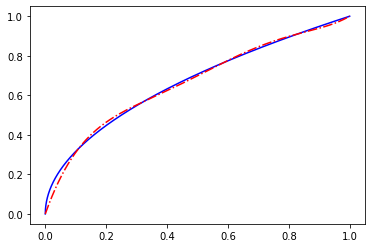

In [158]:
solve_with_constraints(lambda x: np.sqrt(x), 5, bounds=[0,1])

(0.002721517318214 + x*(0.938928960438372 + x*(-0.664598620205411 + x*0.224798782467834)))
MSE is 0.000001


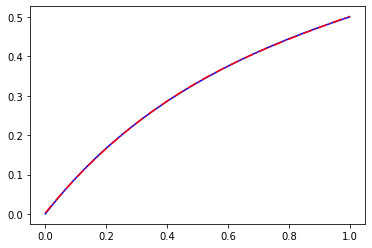

In [159]:
solve(lambda x: x/(x+1), 3)

(0.000000000000000 + x*(0.954278301627844 + x*(-0.685173225190097 + x*0.230894923562253)))
MSE is 0.000001
0.0->0.0,1.0->0.5
vs
0.0->0.0,1.0->0.5


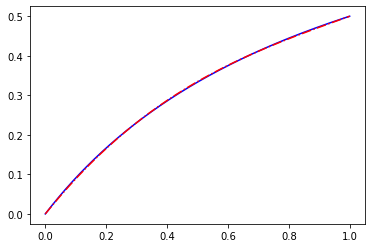

In [160]:
solve_with_constraints(lambda x: x/(x+1), 3)

(0.013961456441606 + x*(0.804049690957671 + x*-0.327400446503659))
MSE is 0.000019


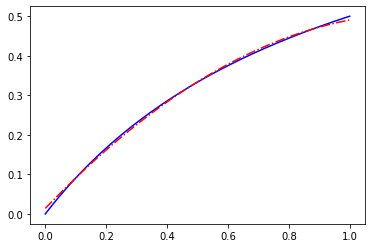

In [175]:
solve(lambda x: x/(x+1), 2)

(0.000000000000000 + x*(0.838830839846718 + x*-0.338830839846718))
MSE is 0.000065
0.0->0.0,1.0->0.49999999999999994
vs
0.0->0.0,1.0->0.5


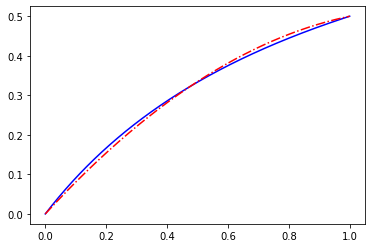

In [176]:
solve_with_constraints(lambda x: x/(x+1), 2)

(0.052426898789506 + x*(-5.004849483378008 + x*(163.550121006373814 + x*(-1846.112515108447042 + x*(10718.793435251431220 + x*(-35727.864954095639405 + x*(72721.112345278481371 + x*(-93321.007200281324913 + x*(75791.723229374038056 + x*(-37775.486890568739909 + x*(10541.113533141840890 + x*-1260.628760853132007)))))))))))
MSE is 0.005668


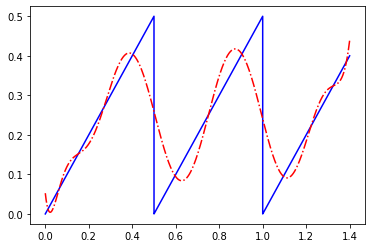

In [173]:
solve(lambda x: np.mod(x, 0.5), 11, bounds=[0,1.4])

(0.000000000000000 + x*(-1.841788455199484 + x*(104.805337328091781 + x*(-1338.391506623980831 + x*(8280.509218541719747 + x*(-28590.521135327904631 + x*(59345.064929686792311 + x*(-76942.489952294403338 + x*(62758.393756453006063 + x*(-31283.778671803240286 + x*(8703.681397280750389 + x*-1035.187614584092444)))))))))))
MSE is 0.005709
0->0.0,1.4->0.40000000000873115
vs
0->0.0,1.4->0.3999999999999999


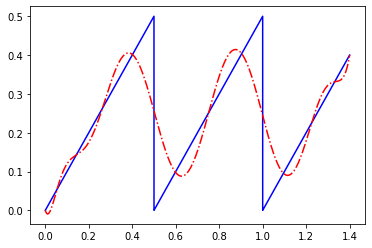

In [174]:
solve_with_constraints(lambda x: np.mod(x, 0.5), 11, bounds=[0,1.4])